This notebook will be used for exploratory data analysis and machine learning. I'll begin importing the tools I plan on using for this.

In [2]:
import pandas as pd
from pandas.api.types import is_numeric_dtype
from sklearn.model_selection import train_test_split
import catboost as cb
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

Picking up from where I left off in the 'Final Capstone Project' notebook, I'll import in the cleaned data-set from before. Exporting data-set adds an additional column, so that needs to be dropped. I'll also take a sample from this data-set even though it'd already been cut down to 1/10th of its original size due to how large it is.

In [3]:
data_final=pd.read_csv('cleaned_data.csv')
data_final=data_final.drop('Unnamed: 0',axis=1)
data_final=data_final.sample(frac=.2)

I'll go ahead and describe my features and my target here.

In [4]:
X=data_final.drop('Accepted',axis=1)
y=data_final['Accepted']

The first learning model I want to use is Catboost. Catboost already supports categorical features without needing to one-hot encode or dummy columns. To prepare to run the model, I'll first make a function that gets the indices of all of the columns with a categorical data-type.

In [5]:
def get_categorical_indicies(X):
    cats = []
    for col in X.columns:
        if is_numeric_dtype(X[col]):
            pass
        else:
            cats.append(col)
    cat_indicies = []
    for col in cats:
        cat_indicies.append(X.columns.get_loc(col))
    return cat_indicies

categorical_indicies = get_categorical_indicies(X)

Next, I need a function that converts any categorical columns into the data type Catboost requires.

In [6]:
def convert_cats(X):
    cats = []
    for col in X.columns:
        if is_numeric_dtype(X[col]):
            pass
        else:
            cats.append(col)
    cat_indicies = []
    for col in cats:
        X[col] = X[col].astype('category')

convert_cats(X)

I'll go ahead and split my data into training and testing sets now.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101, stratify=y)

Before I start, I want to check the survival rate of the test and see if the data is imbalanced.

In [8]:
print('Test Survival Rate:',y_test.sum()/y_test.count())

Test Survival Rate: 0.19642027478484037


It's imbalanced, so I'll undersample the training data before I begin.

In [9]:
train_df = pd.concat([X,y],axis=1)
accepted = train_df[train_df['Accepted']==1]
rejected = train_df[train_df['Accepted']==0]
rejected = rejected.sample(n=len(accepted), random_state=101)
train_df = pd.concat([accepted,rejected],axis=0)
X_train = train_df.drop('Accepted',axis=1)
y_train = train_df['Accepted']

I'm now ready to train the model. I'm going to go with Catboost's built-in grid-search method. I'll separate out the data_sets into a training and testing set, create the model, and run the search.

In [10]:
train_dataset = cb.Pool(X_train,y_train, cat_features=categorical_indicies)
test_dataset = cb.Pool(X_test,y_test, cat_features=categorical_indicies)

In [11]:
model = cb.CatBoostClassifier(loss_function='Logloss', eval_metric='Accuracy')

In [12]:
grid = {'learning_rate': [0.03],
'depth': [4],
'l2_leaf_reg': [1],
'iterations': [50]}

In [13]:
model.grid_search(grid,train_dataset)

0:	learn: 0.9223881	test: 0.9207592	best: 0.9207592 (0)	total: 179ms	remaining: 8.76s
1:	learn: 0.9207970	test: 0.9190133	best: 0.9207592 (0)	total: 208ms	remaining: 5s
2:	learn: 0.9232611	test: 0.9214350	best: 0.9214350 (2)	total: 237ms	remaining: 3.71s
3:	learn: 0.9248944	test: 0.9226177	best: 0.9226177 (3)	total: 272ms	remaining: 3.13s
4:	learn: 0.9248240	test: 0.9224487	best: 0.9226177 (3)	total: 309ms	remaining: 2.78s
5:	learn: 0.9251619	test: 0.9227867	best: 0.9227867 (5)	total: 341ms	remaining: 2.5s
6:	learn: 0.9251197	test: 0.9227867	best: 0.9227867 (5)	total: 372ms	remaining: 2.29s
7:	learn: 0.9251619	test: 0.9227867	best: 0.9227867 (5)	total: 407ms	remaining: 2.14s
8:	learn: 0.9253309	test: 0.9228993	best: 0.9228993 (8)	total: 434ms	remaining: 1.98s
9:	learn: 0.9254576	test: 0.9230683	best: 0.9230683 (9)	total: 463ms	remaining: 1.85s
10:	learn: 0.9253872	test: 0.9230119	best: 0.9230683 (9)	total: 498ms	remaining: 1.76s
11:	learn: 0.9254013	test: 0.9231246	best: 0.9231246 (11)

49:	learn: 0.9469620	test: 0.9493782	best: 0.9494458 (48)	total: 1.47s	remaining: 0us

bestTest = 0.9494457962
bestIteration = 48

Training on fold [1/3]
0:	learn: 0.9214146	test: 0.9219384	best: 0.9219384 (0)	total: 27.9ms	remaining: 1.37s
1:	learn: 0.9244052	test: 0.9254528	best: 0.9254528 (1)	total: 56.5ms	remaining: 1.35s
2:	learn: 0.9243883	test: 0.9254528	best: 0.9254528 (1)	total: 83.6ms	remaining: 1.31s
3:	learn: 0.9244390	test: 0.9254528	best: 0.9254528 (1)	total: 114ms	remaining: 1.31s
4:	learn: 0.9247601	test: 0.9256556	best: 0.9256556 (4)	total: 140ms	remaining: 1.26s
5:	learn: 0.9244728	test: 0.9252501	best: 0.9256556 (4)	total: 168ms	remaining: 1.23s
6:	learn: 0.9247432	test: 0.9254866	best: 0.9256556 (4)	total: 196ms	remaining: 1.21s
7:	learn: 0.9247432	test: 0.9254528	best: 0.9256556 (4)	total: 230ms	remaining: 1.21s
8:	learn: 0.9247263	test: 0.9254866	best: 0.9256556 (4)	total: 265ms	remaining: 1.21s
9:	learn: 0.9247601	test: 0.9254866	best: 0.9256556 (4)	total: 295ms	

42:	learn: 0.9403217	test: 0.9381928	best: 0.9381928 (42)	total: 1.3s	remaining: 212ms
43:	learn: 0.9473168	test: 0.9468099	best: 0.9468099 (43)	total: 1.32s	remaining: 181ms
44:	learn: 0.9472662	test: 0.9468099	best: 0.9468099 (43)	total: 1.35s	remaining: 151ms
45:	learn: 0.9476717	test: 0.9469789	best: 0.9469789 (45)	total: 1.39s	remaining: 121ms
46:	learn: 0.9482968	test: 0.9470465	best: 0.9470465 (46)	total: 1.41s	remaining: 90.1ms
47:	learn: 0.9484151	test: 0.9469789	best: 0.9470465 (46)	total: 1.44s	remaining: 59.9ms
48:	learn: 0.9484827	test: 0.9470803	best: 0.9470803 (48)	total: 1.47s	remaining: 29.9ms
49:	learn: 0.9484827	test: 0.9469789	best: 0.9470803 (48)	total: 1.49s	remaining: 0us

bestTest = 0.947080292
bestIteration = 48



{'params': {'depth': 4,
  'l2_leaf_reg': 1,
  'iterations': 50,
  'learning_rate': 0.03},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,

I want to see the optimum parameters found in the grid search before I begin evaluating the model.

In [14]:
model.get_params()

{'loss_function': 'Logloss',
 'eval_metric': 'Accuracy',
 'depth': 4,
 'l2_leaf_reg': 1,
 'iterations': 50,
 'learning_rate': 0.03}

Next, I'll use the model to make predictions for my test and make and review a classification report.

In [15]:
pred = model.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95     36321
           1       0.77      0.92      0.84      8878

    accuracy                           0.93     45199
   macro avg       0.87      0.93      0.90     45199
weighted avg       0.94      0.93      0.93     45199



93% accuracy is pretty good. Next, I'll write a function to plot the importance of each feature.

In [16]:
def plot_feature_importance(importance,names,model_type):

#Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

#Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

#Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

#Define size of bar plot
    plt.figure(figsize=(10,8))
#Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
#Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

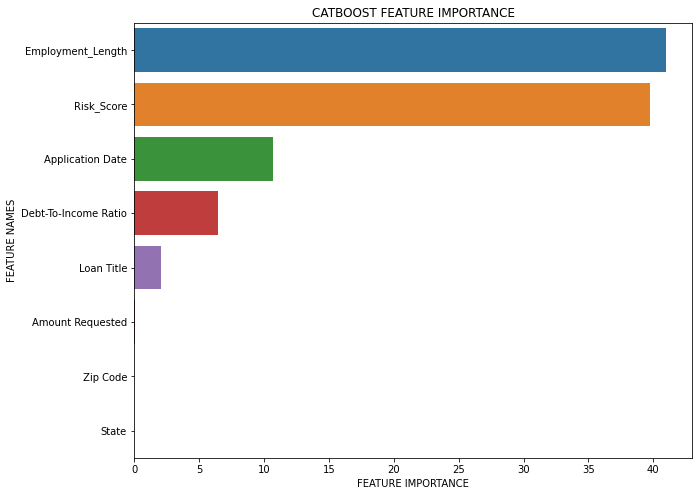

In [17]:
plot_feature_importance(model.get_feature_importance(),X.columns,'CATBOOST')

The majority of my categorical variables aren't of much use. Loan Title matters a little. I'd hypothesized that Risk Score would be the most relevant based on my experience in sales, but Employment Length beat it out very slightly.

Next, I wanted to check the lift.

In [19]:
def plot_lift_curve(y_val, y_pred, step=0.01):
    aux_lift = pd.DataFrame()
    aux_lift['real'] = y_val
    aux_lift['predicted'] = y_pred
    aux_lift.sort_values('predicted',ascending=False,inplace=True)
    
    x_val = np.arange(step,1+step,step)
    ratio_ones = aux_lift['real'].sum() / len(aux_lift)
    y_v = []
    
    for x in x_val:
        num_data = int(np.ceil(x*len(aux_lift))) #The ceil function returns the closest integer bigger than our number 
        data_here = aux_lift.iloc[:num_data,:]   # ie. np.ceil(1.4) = 2
        ratio_ones_here = data_here['real'].sum()/len(data_here)
        y_v.append(ratio_ones_here / ratio_ones)
           
    fig, axis = plt.subplots()
    fig.figsize = (40,40)
    axis.plot(x_val, y_v, 'g-', linewidth = 3, markersize = 5)
    axis.plot(x_val, np.ones(len(x_val)), 'k-')
    axis.set_xlabel('Proportion of sample')
    axis.set_ylabel('Lift')
    plt.title('Lift Curve')
    plt.show()

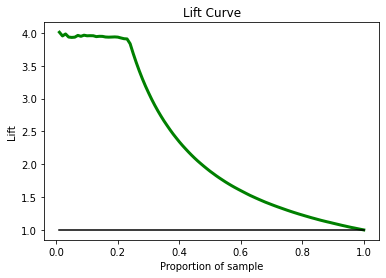

In [20]:
plot_lift_curve(y_test,pred,step=0.01)

Looks like the model will beat random sampling for 25% of the data.

I'll go ahead and check the ROC curve as well.

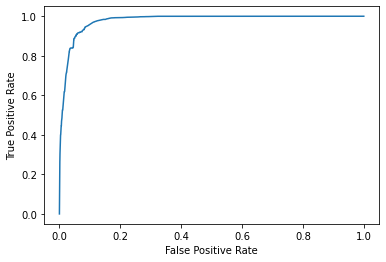

In [21]:
from sklearn import metrics

y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The ROC curve also heavily favors the learning model, far outpacing a random classifier.

I wanted to check the dates a little more closely as well.

In [22]:
data_final.groupby('Application Date')['Accepted'].describe()

,count,mean,std,min,25%,50%,75%,max
Application Date,,,,,,,,
2007Q2,2.0,0.500000,0.707107,0.0,0.25,0.5,0.75,1.0
2007Q3,17.0,0.235294,0.437237,0.0,0.00,0.0,0.00,1.0
2007Q4,82.0,0.097561,0.298546,0.0,0.00,0.0,0.00,1.0
2008Q1,164.0,0.140244,0.348303,0.0,0.00,0.0,0.00,1.0
2008Q2,112.0,0.080357,0.273067,0.0,0.00,0.0,0.00,1.0
2008Q3,64.0,0.078125,0.270490,0.0,0.00,0.0,0.00,1.0
2008Q4,155.0,0.064516,0.246466,0.0,0.00,0.0,0.00,1.0
2009Q1,190.0,0.063158,0.243889,0.0,0.00,0.0,0.00,1.0
2009Q2,311.0,0.083601,0.277235,0.0,0.00,0.0,0.00,1.0


2007 isn't entirely accounted for. There's probably some economic data somewhere that could better explain why some years outperform others, but it seems arbitrary upon examination.

I want to run a lightgbm model as well. I'll start by importing the necessary packages and creating and fitting a model.

In [23]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
          verbose=20,eval_metric='logloss')

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning:

categorical_column in param dict is overridden.



[20]	training's binary_logloss: 0.174357	valid_0's binary_logloss: 0.185696
[40]	training's binary_logloss: 0.0999256	valid_0's binary_logloss: 0.116335
[60]	training's binary_logloss: 0.0707389	valid_0's binary_logloss: 0.0947264
[80]	training's binary_logloss: 0.058098	valid_0's binary_logloss: 0.0892988
[100]	training's binary_logloss: 0.0499303	valid_0's binary_logloss: 0.0868858


LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42)

In [24]:
print('Training accuracy {:.4f}'.format(model.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(model.score(X_test,y_test)))

Training accuracy 0.9836
Testing accuracy 0.9678


Let's check the feature importance of this model.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

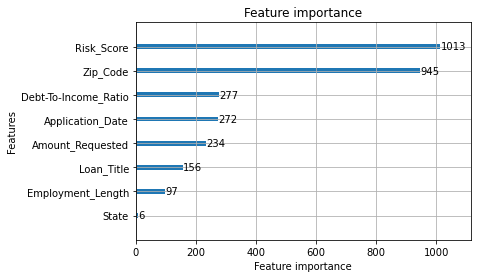

In [25]:
lgb.plot_importance(model)

Risk Score performed well again, but Employment Length saw quite the drop off. 

Based on the data assembled here; Risk Score seems to be the main determing factor in loan approval.